2 nuts. bug 1: 1, 2. bug 2: 1, 2 or 2, 1. dilution rate D. See for different g where the sum is e.g. 5 what would the mutual invasion be like. might be trivial..

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

def log(x):
    return math.log(x)
D = 1000
w = [log(D/2)/log(D), log(2)/log(D)]
scale = 100
budget = 1
def coexist1(g1, g2, weight = w):
    return (g1[0]/g2[0]*w[0]+g1[1]/g2[1]*w[1]>1 and g2[0]/g1[0]*w[0]+g2[1]/g1[1]*w[1]>1)

mat1 = np.zeros([scale, scale])
for i in range(scale):
    for j in range(scale):
        mat1[i][j] = coexist1([(i+1)*budget/(scale+1), (scale-i)*budget/(scale+1)], [(j+1)*budget/(scale+1), (scale-j)*budget/(scale+1)])

0.0

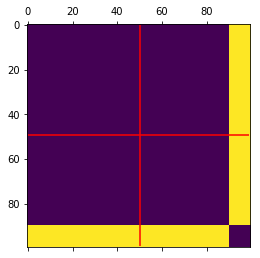

In [53]:
plt.matshow(mat1)

plt.hlines(49, 0, 99, color = 'r')
plt.vlines(50, 0, 99, color = 'r')
mat1[5][5]

In [50]:
def coexist2(g1, g2, weight = w):
    return (g1[0]/g2[1]*w[0]+g1[0]/g2[0]*w[1]>1 and g2[1]/g1[0]*w[0]+g2[1]/g1[1]*w[1]>1)

mat2 = np.zeros([scale, scale])
for i in range(scale):
    for j in range(scale):
        mat2[i][j] = coexist2([(i+1)*budget/(scale+1), (scale-i)*budget/(scale+1)], [(scale-j)*budget/(scale+1),(j+1)*budget/(scale+1)])

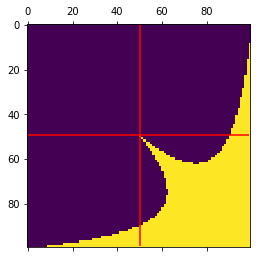

In [24]:
plt.matshow(mat2)
plt.hlines(49, 0, 99, color = 'r')
plt.vlines(50, 0, 99, color = 'r')

Tolerable states are more for diff. order when D is larger, vice versa.

In [26]:
print(sum(sum(mat1)))
print(sum(sum(mat2)))

1800.0
2166.0


Seems like that same preferential order case excludes generalists, but under different order case some can survive.

In [25]:
coexist2([0.6, 0.4], [0.4, 0.6])

True

now I try to see if we have 2 nuts 2 species, how uninvadable would the system be dependent upon the species preferential order. 

In [88]:
import numpy as np
import math
import random
import itertools
from scipy.optimize import root
import copy
import time

b0 = 1e-5 # density of bug when introduced/initial
b_threshold = 1e-5 # extinction density
c_threshold = 1e-9 # concentration threshold
D = 1e-3
tau = 0 # lag
T_dilute = 20 # time interval between dilutions

def dilute(system, config):
    
    Nr = config.nr
    Nb = config.nb
    preference_list = config.prefs
    growth_rate_list = config.gs
    yields_list = config.ys
    
    #global t_system
    t_points = []
    n_points = []
    ni = 0
    t_switch = 0
    while t_switch < T_dilute:
        #list of resource in use for each consumer
        use = [0 for i in range(Nb)]
        # list of consumers for each resource
        consumer = [[] for i in range(Nr)]
        for i in range(Nb):
            # if all are depleted, bug still uses its least preferred nutrient
            while system['res_available'][preference_list[i][use[i]]] < 1 and use[i] < Nr - 1:
                use[i] = use[i] + 1
            if system['bug_available'][i] > 0:
                consumer[preference_list[i][use[i]]].append(i)
        # find the earliest depleted resource
        t_dep = T_dilute - t_switch
        for i in range(Nr):
            if system['res_available'][i] > 0:
                def remain(t):
                    # S = c - sum(B0(e^gt-1)/Y)
                    return system['res_concentration'][i] - sum([system['bug_density'][j]*(math.exp(t*growth_rate_list[j][i]) - 1)/yields_list[j][i] for j in consumer[i]])
                # a little bit tricky here...
                t_i = root(remain, T_dilute + 1).x[0]
                if t_i < t_dep:
                    t_dep = t_i
                    ni = i
        # update the system according to this t_dep
        t_switch = t_switch + t_dep
        t_points.append(t_dep)
        n_points.append(ni)
        temp_bug_density = [i for i in system['bug_density']]
        for i in range(Nb):
            if system['res_available'][preference_list[i][use[i]]] > 0:
                temp_bug_density[i] = system['bug_density'][i]*math.exp(growth_rate_list[i][preference_list[i][use[i]]]*t_dep)
        for i in range(Nr):
            if system['res_available'][i] > 0:
                system['res_concentration'][i] = system['res_concentration'][i] - sum([system['bug_density'][j]*(math.exp(t_dep*growth_rate_list[j][i]) - 1)/yields_list[j][i] for j in consumer[i]])
                if system['res_concentration'][i] < c_threshold:
                    system['res_available'][i] = 0
        for i in range(Nb):
            system['bug_density'][i] = temp_bug_density[i]
    #print(system)
    #system_copy = copy.deepcopy(system)
    #t_system.append(system_copy)
    #print("diluted once")
    n_points = n_points[:-1]
    return system, t_points, n_points

def move_to_new(system, config):
    Nr = config.nr
    Nb = config.nb
    system['bug_density'] = [(i*D > b_threshold)*i*D for i in system['bug_density']]
    system['bug_available'] = [1*(system['bug_density'][i] > b_threshold) for i in range(Nb)]
    system['res_concentration'] = [(system['res_concentration'][i]*D + 1.0) / (D + 1) for i in range(Nr)]
    system['res_available'] = [1*(system['res_concentration'][i] > c_threshold) for i in range(Nr)]
    return system

def output(system):
    survivors = [i for i, v in enumerate(system['bug_available']) if v != 0]
    pref_list = []
    concent = []
    growth = []
    for i in survivors:
        pref_list.append(preference_list[i])
        concent.append(system['bug_density'][i])
        growth.append(growth_rate_list[i])
    return survivors, concent, pref_list, growth

class config:
    def __init__(self, n_bacteria, n_nutrients, preference_list, g_list, Y_list):
        self.nb = n_bacteria
        self.nr = n_nutrients
        self.prefs = preference_list
        self.gs = g_list
        self.ys = Y_list
    def add_nutrient(self, prefs_new, g_new, Y_new):
        self.nr = self.nr + 1
        for i in range(self.nb):
            # prefs_new is the list of how popular this new nutrient is for each bacteria
            self.prefs[i].insert(prefs_new[i], self.nr)
            self.gs[i].append(g_new[i])
            # needs normalization to keep this budget
            sumed = sum(self.gs[i])
            self.gs[i] = [g/sumed for g in self.gs[i]]
            self.ys[i].append(Y_new[i])
    def add_bug(self, prefs_new, g_new, Y_new):
        self.nb = self.nb + 1
        self.prefs.append(prefs_new)
        self.gs.apend(g_new)
        self.ys.append(Y_new)
        
def find_balance(config0, b0_list, times = 10):
    system = {'res_available': np.ones(config0.nb), 'res_concentration': [1.0 for i in range(config0.nr)], 'bug_available': [1 for i in range(config0.nb)], 'bug_density': b0_list}
    for i in range(times):
        system, t_points, n_points = dilute(system, config0)
        system = move_to_new(system, config0)
        #print(times)
    return system, t_points, n_points
        
def invadable(config0, t_points, n_points, prefs_inv, g_inv, D):
    prefs_temp = prefs_inv.copy()
    growth = 0
    for i in range(len(t_points) - 1):
        growth = growth + t_points[i]*g_inv[prefs_temp[0]]
        #print(prefs_temp[0])
        prefs_temp.remove(n_points[i])
    # this D is larger than 1
    return growth - log(D)

In [20]:
config0 = config(2, 2, [[0, 1], [0, 1]], [[0.8, 0.2], [0.3, 0.7]], [[1, 1], [1, 1]])
system, tps, nps = find_balance(config0, [0.2, 0.2])

In [21]:
invadable(config0, tps, nps, [1, 0], [0.1, 0.9], 1000)

3.199467830638424

In [106]:
scale = 50
mat000 = np.zeros([scale, scale])
for i in range(scale):
    #print(i)
    for j in range(scale):
        config1 = config(2, 2, [[0, 1], [0, 1]], [[i/scale, 1-i/scale], [j/scale, 1-j/scale]], [[1, 1], [1, 1]])
        system, tps, nps = find_balance(config1, [0.2, 0.2])
        if(sum(system['bug_available'])==2):
            mat000[i][j] += 50
            for k in range(scale+1):
                if(invadable(config1, tps, nps, [0, 1], [k/scale, 1-k/scale], 1000)>0):
                    mat000[i][j]+= 1
        #mat00[i][j] = (sum(system['bug_available'])==2)

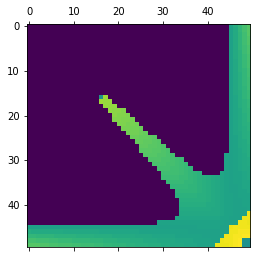

In [107]:
plt.matshow(mat000)

In [108]:
scale = 50
mat001 = np.zeros([scale, scale])
for i in range(scale):
    #print(i)
    for j in range(scale):
        config1 = config(2, 2, [[0, 1], [0, 1]], [[i/scale, 1-i/scale], [j/scale, 1-j/scale]], [[1, 1], [1, 1]])
        system, tps, nps = find_balance(config1, [0.2, 0.2])
        if(sum(system['bug_available'])==2):
            mat001[i][j] += 50
            for k in range(scale+1):
                if(invadable(config1, tps, nps, [1, 0], [k/scale, 1-k/scale], 1000)>0):
                    mat001[i][j]+= 1
        #mat00[i][j] = (sum(system['bug_available'])==2)

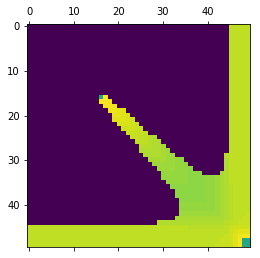

In [109]:
plt.matshow(mat001)

In [113]:
sum(sum(mat000))

45729.0

In [133]:
config0 = config(2, 2, [[0, 1], [1, 0]], [[0.8, 0.2], [0.2, 0.8]], [[1, 1], [1, 1]])
system, tps, nps = find_balance(config0, [0.2, 0.2])

In [134]:
system

{'res_available': [1, 1],
 'res_concentration': [0.9990009990009991, 0.9990009990009991],
 'bug_available': [1, 1],
 'bug_density': [0.0010000010000009991, 0.0010000010000009991]}

In [129]:
invadable(config0, tps, nps, [1, 0], [0.01, 0.99], 1000)

-0.15326375802285153

In [104]:
scale = 50
mat010 = np.zeros([scale, scale])
for i in range(scale):
    #print(i)
    for j in range(scale):
        config1 = config(2, 2, [[0, 1], [1, 0]], [[i/scale, 1-i/scale], [j/scale, 1-j/scale]], [[1, 1], [1, 1]])
        system, tps, nps = find_balance(config1, [0.2, 0.2])
        if(sum(system['bug_available'])==2):
            mat010[i][j] += 50
            for k in range(scale+1):
                if(invadable(config1, tps, nps, [0, 1], [k/scale, 1-k/scale], 1000)>0):
                    mat010[i][j]+= 1
        #mat00[i][j] = (sum(system['bug_available'])==2)

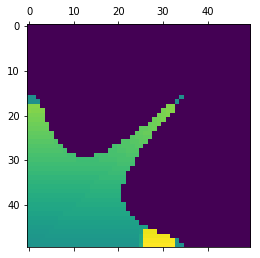

In [105]:
plt.matshow(mat010)

In [115]:
sum(sum(mat011))

40707.0

In [110]:
scale = 50
mat011 = np.zeros([scale, scale])
for i in range(scale):
    #print(i)
    for j in range(scale):
        config1 = config(2, 2, [[0, 1], [1, 0]], [[i/scale, 1-i/scale], [j/scale, 1-j/scale]], [[1, 1], [1, 1]])
        system, tps, nps = find_balance(config1, [0.2, 0.2])
        if(sum(system['bug_available'])==2):
            mat011[i][j] += 50
            for k in range(scale):
                if(invadable(config1, tps, nps, [1, 0], [k/scale, 1-k/scale], 1000)>0):
                    mat011[i][j]+= 1
        #mat00[i][j] = (sum(system['bug_available'])==2)

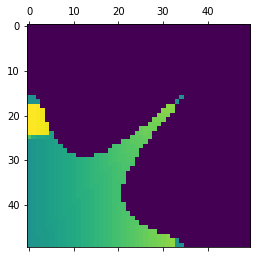

In [111]:
plt.matshow(mat011)

In [132]:
mat011[16]

array([50., 50.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 50.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [8]:
import matplotlib.pyplot as plt
import numpy as np
a = [[0, 1], [0, 1]]
plt.matshow(a)
plt.xlabel('x')
plt.xticks(np.arange(0, 10, 5))

([<matplotlib.axis.XTick at 0x2bd8ba66278>,
 <a list of 2 Text xticklabel objects>)

In [12]:
%store -r allGR
%store -r allNE

In [13]:
NE_exist = []
for elem in allNE:
    NE_exist.append(sum([i!=[] for i in elem]))

Text(0,0.5,'# of times that gives at least 1 NE')

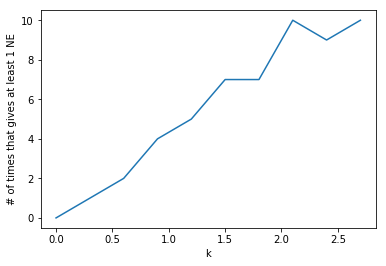

In [14]:
plt.plot([i*0.3 for i in range(10)], NE_exist)
plt.xlabel('k')
plt.ylabel('# of times that gives at least 1 NE')

In [15]:
NE_expect = []
for elem in allNE:
    NE_expect.append(sum([len(i) for i in elem]))

Text(0,0.5,'avr number of NE')

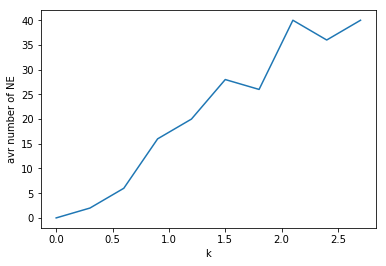

In [16]:
plt.plot([i*0.3 for i in range(10)], NE_expect)
plt.xlabel('k')
plt.ylabel('avr number of NE')

In [3]:
allNE

NameError: name 'allNE' is not defined

In [4]:
allGR

NameError: name 'allGR' is not defined

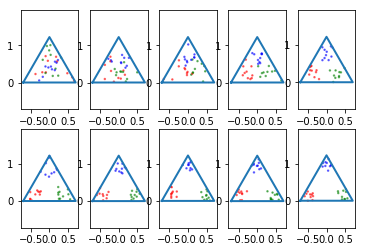

In [19]:
import math
from matplotlib.patches import Circle
def plot_triangle(A, B, C):
    x = [A[0], B[0], C[0], A[0]]
    y = [A[1], B[1], C[1], A[1]]
    ax = plt.gca()
    ax.plot(x, y, linewidth=2)

def draw_circle(x, y, r, c):
    ax = plt.gca()
    cir = Circle(xy=(x, y), radius=r, alpha=0.5, color = c)
    ax.add_patch(cir)
    ax.plot()
    
def project(data):
    draw_circle((data[0][1]-data[0][0])/math.sqrt(2)/sum(data[0]), data[0][2]*math.sqrt(6)/2/sum(data[0]), 0.02, 'r')
    draw_circle((data[1][1]-data[1][0])/math.sqrt(2)/sum(data[1]), data[1][2]*math.sqrt(6)/2/sum(data[1]), 0.02, 'g')
    draw_circle((data[2][1]-data[2][0])/math.sqrt(2)/sum(data[2]), data[2][2]*math.sqrt(6)/2/sum(data[2]), 0.02, 'b')



for idx, GRlist in enumerate(allGR):
    #print(idx)
    plt.subplot('25'+str((idx+1)%10))
    plt.axis('equal')
    plot_triangle([-math.sqrt(2)/2, 0], [math.sqrt(2)/2, 0], [0, math.sqrt(6)/2])
    for GR in GRlist:
        project(GR)

        

In [2]:
a = [1, 2, 3]
a[-1]

3